# Import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier

# Load Datasets

In [5]:
df = pd.read_csv("fraud.csv")  

df.head(), df.shape


(   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
 0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
 1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
 2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
 3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
 4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   
 
       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
 0  M1979787155             0.0             0.0        0               0  
 1  M2044282225             0.0             0.0        0               0  
 2   C553264065             0.0             0.0        1               0  
 3    C38997010         21182.0             0.0        1               0  
 4  M1230701703             0.0             0.0        0               0  ,
 (6362620, 11))

# Exploratory Data Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
# Check class imbalance
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [12]:
# Fraud by transaction type
pd.crosstab(df['type'], df['isFraud'], normalize='index')

isFraud,0,1
type,,
CASH_IN,1.000000,0.000000
CASH_OUT,0.998160,0.001840
DEBIT,1.000000,0.000000
PAYMENT,1.000000,0.000000
TRANSFER,0.992312,0.007688


# Data Cleaning

In [52]:
# Missing Values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
amount_log        0
dtype: int64


In [56]:
# Drop Irrelevant Columns
df = df.drop(columns=['nameOrig', 'nameDest'], errors='ignore')

In [19]:
# Encode Categorical Variable
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [21]:
# Handle Outliers (Log Transformation)
df['amount_log'] = np.log1p(df['amount'])

In [23]:
# Feature & Target Split
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

In [25]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [27]:
# Model Building (Random Forest)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [28]:
# Model Prediction
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Model Evaluation

In [31]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.09      0.99      0.16      1643

    accuracy                           0.99   1272524
   macro avg       0.54      0.99      0.58   1272524
weighted avg       1.00      0.99      0.99   1272524



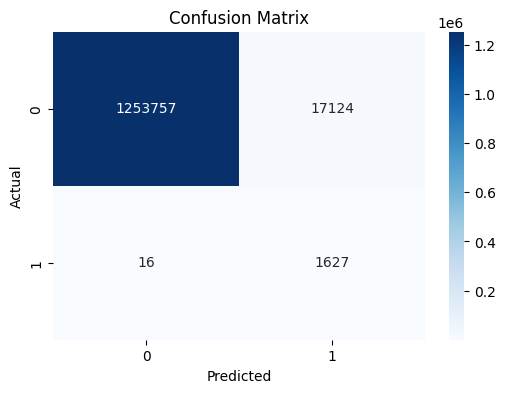

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
# ROC-AUC Curve
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

np.float64(0.9993467572080247)

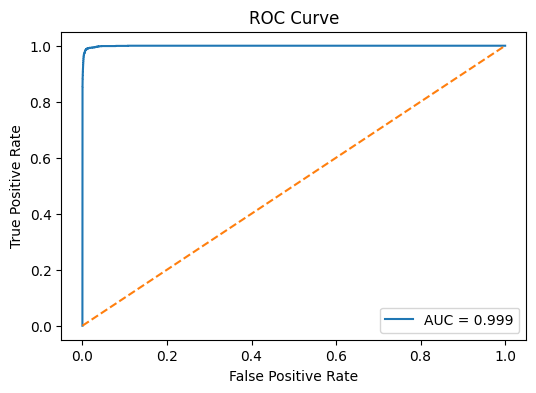

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance 

In [36]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance

,feature,importance
3,oldbalanceOrg,0.285590
4,newbalanceOrig,0.160065
1,type,0.152318
2,amount,0.150937
7,amount_log,0.097745
0,step,0.072487
6,newbalanceDest,0.046483
5,oldbalanceDest,0.034374


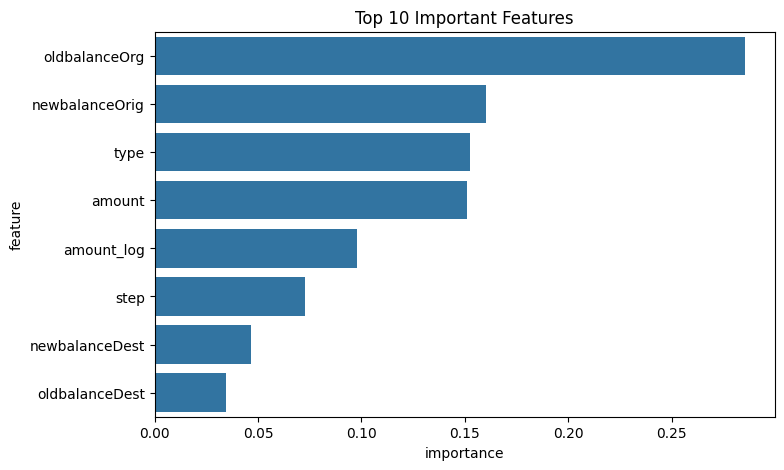

In [37]:
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title("Top 10 Important Features")
plt.show()

# Business Insights

# Prevention Strategy

# Measuring Success

# Summary 